In [1]:
import pandas as pd

### 시각화 라이브러리 정의
# - 파이썬에서 사용되는 기본 시각화 라이브러리
import matplotlib.pyplot as plt

# - 히트맵 라이브러리
import seaborn as sns
import geopandas as gpd
import folium
from shapely.geometry import Polygon

import os

import numpy as np
from sklearn.cluster import KMeans
import requests
import time
import io

from scipy.interpolate import RBFInterpolator

from math import radians, sin, cos, sqrt, atan2


### 한글처리
plt.rc("font", family="Malgun Gothic")

# - 마이너스 기호 깨짐 처리
plt.rcParams["axes.unicode_minus"] = False

In [2]:
# 캐나다 경계 좌표
lat_range = (48.3, 60.0)
lon_range = (-139.0, -114.0)

# 0.1도 간격 격자 생성 (약 10km)
lat_points = np.arange(lat_range[0], lat_range[1], 0.1)
lon_points = np.arange(lon_range[0], lon_range[1], 0.1)
grid = [(lat, lon) for lat in lat_points for lon in lon_points]
grid_df = pd.DataFrame(grid, columns=["latitude", "longitude"])

# K-Means 클러스터링: 캘리포니아 좌표를 50개의 대표 좌표로 압축
# 목적: API 요청 횟수를 줄이고 데이터 크기를 줄이면서 지역적 대표성을 유지
kmeans = KMeans(n_clusters=50, random_state=42)
grid_df["cluster"] = kmeans.fit_predict(grid_df[["latitude", "longitude"]])
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=["latitude", "longitude"])

# 클러스터링 결과 확인
print("클러스터 중심 좌표 (50개 대표 좌표):")
print(cluster_centers.head())

# 클러스터 중심에서 기상 데이터 수집
start_date = "20150101"
end_date = "20250228"

def get_skiprows(response_text):
    lines = response_text.splitlines()
    skiprows = 0
    for line in lines:
        if line.strip() == "YEAR,DOY,T2M,WS2M,RH2M,PRECTOTCORR":
            break
        skiprows += 1
    return skiprows

def get_weather_data(latitude, longitude):
    url = f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters=T2M,WS2M,RH2M,PRECTOTCORR&community=AG&longitude={longitude}&latitude={latitude}&start={start_date}&end={end_date}&format=CSV"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        if response.status_code == 200:
            # 응답 데이터 구조 확인 (디버깅용)
            print(f"응답 데이터 상단 15줄 (위도: {latitude}, 경도: {longitude}):")
            print("\n".join(response.text.splitlines()[:15]))
            # 동적으로 skiprows 계산
            skiprows = get_skiprows(response.text)
            return pd.read_csv(io.StringIO(response.text), skiprows=skiprows, header=0)
        else:
            print(f"데이터 요청 실패! 상태 코드: {response.status_code}, 위도: {latitude}, 경도: {longitude}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"요청 오류 발생: {e}, 위도: {latitude}, 경도: {longitude}")
        return None

weather_data_list = []
for idx, row in cluster_centers.iterrows():
    print(f"요청 중: 클러스터 {idx} (위도 {row['latitude']}, 경도 {row['longitude']})")
    weather_data = get_weather_data(row["latitude"], row["longitude"])
    if weather_data is not None:
        weather_data["latitude"] = row["latitude"]
        weather_data["longitude"] = row["longitude"]
        weather_data_list.append(weather_data)
    time.sleep(5)  # API 요청 간 대기

# 데이터프레임 병합
weather_df = pd.concat(weather_data_list, ignore_index=True)

# acq_date 생성
weather_df["acq_date"] = pd.to_datetime(weather_df["YEAR"].astype(str) + weather_df["DOY"].astype(str), format="%Y%j")

# 결과 출력
print("\n기상 데이터 정보:")
print(weather_df.info())
print(weather_df.head(5))

# 저장
weather_df.to_csv("./weather_data.csv", index=False)

클러스터 중심 좌표 (50개 대표 좌표):
    latitude   longitude
0  53.989323 -135.389323
1  56.955335 -122.022423
2  54.116865 -115.280920
3  49.546530 -126.683281
4  55.365152 -127.065320
요청 중: 클러스터 0 (위도 53.989323308270755, 경도 -135.3893233082709)
응답 데이터 상단 15줄 (위도: 53.989323308270755, 경도: -135.3893233082709):
-BEGIN HEADER-
NASA/POWER Source Native Resolution Daily Data 
Dates (month/day/year): 01/01/2015 through 02/28/2025 in LST
Location: latitude  53.9893   longitude -135.3893 
elevation from MERRA-2: Average for 0.5 x 0.625 degree lat/lon region = 0.0 meters
The value for missing source data that cannot be computed or is outside of the sources availability range: -999 
parameter(s): 
T2M             MERRA-2 Temperature at 2 Meters (C) 
WS2M            MERRA-2 Wind Speed at 2 Meters (m/s) 
RH2M            MERRA-2 Relative Humidity at 2 Meters (%) 
PRECTOTCORR     MERRA-2 Precipitation Corrected (mm/day) 
-END HEADER-
YEAR,DOY,T2M,WS2M,RH2M,PRECTOTCORR
2015,1,7.49,11.96,85.18,3.24
2015,2,6.68,8.8

In [ ]:
# Haversine 공식으로 거리 계산
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # 지구 반지름 (km)
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

# IDW(역거리 가중 보간) 함수
def idw_interpolation(row, weather_df, weather_vars):
    # 동일 날짜의 기상 데이터만 필터링
    weather_subset = weather_df[weather_df["acq_date"] == row["acq_date"]]
    if weather_subset.empty:
        return pd.Series([None] * len(weather_vars), index=weather_vars)
    
    distances = weather_subset.apply(
        lambda w: haversine(row["latitude"], row["longitude"], w["latitude"], w["longitude"]), axis=1
    )
    # 거리가 0인 경우를 방지하기 위해 최소값 설정
    distances = distances.replace(0, 1e-10)
    weights = 1 / (distances ** 2)
    weighted_sum = (weather_subset[weather_vars].multiply(weights, axis=0)).sum()
    return weighted_sum / weights.sum()

# 1. 산불 데이터 로드
wildfire_dfs = {
    'aS1': pd.read_csv("./DL_FIRE_SV-C2_590678/fire_archive_SV-C2_590678.csv"),
    'nS1': pd.read_csv("./DL_FIRE_SV-C2_590678/fire_nrt_SV-C2_590678.csv"),
}

# 2. 날씨 데이터 로드
weather_df = pd.read_csv("./weather_data.csv")

# 3. 성능 최적화: dtypes 최적화
# 메모리 사용량을 줄이기 위해 float32 사용
for df in wildfire_dfs.values():
    df["latitude"] = df["latitude"].astype("float32")
    df["longitude"] = df["longitude"].astype("float32")

weather_df["latitude"] = weather_df["latitude"].astype("float32")
weather_df["longitude"] = weather_df["longitude"].astype("float32")
weather_df["T2M"] = weather_df["T2M"].astype("float32")
weather_df["WS2M"] = weather_df["WS2M"].astype("float32")
weather_df["RH2M"] = weather_df["RH2M"].astype("float32")
weather_df["PRECTOTCORR"] = weather_df["PRECTOTCORR"].astype("float32")

# 4. 산불 데이터 처리
for df in wildfire_dfs.values():
    df["acq_date"] = pd.to_datetime(df["acq_date"])

wildfire_df = pd.concat(wildfire_dfs.values(), ignore_index=True)

# 5. 기상 데이터 처리
weather_df["acq_date"] = pd.to_datetime(weather_df["YEAR"].astype(str) + weather_df["DOY"].astype(str), format="%Y%j")

# 성능 최적화: 병합 전 필터링 (2025-03-01 이전 데이터만 사용)
cutoff_date = pd.Timestamp("2025-03-01")
weather_df = weather_df[weather_df["acq_date"] <= cutoff_date]
wildfire_df = wildfire_df[wildfire_df["acq_date"] <= cutoff_date]

# 6. 기상 데이터 보간 (클러스터별로 RBF 보간)
# 클러스터 식별을 위해 latitude와 longitude 조합으로 고유 키 생성
weather_df["cluster_id"] = weather_df["latitude"].astype(str) + "_" + weather_df["longitude"].astype(str)

# 보간 전 결측치 확인
print("보간 전 결측치:")
print(weather_df[["T2M", "WS2M", "RH2M", "PRECTOTCORR"]].isnull().sum())

# RBF 보간 적용
weather_vars = ["T2M", "WS2M", "RH2M", "PRECTOTCORR"]
for cluster_id in weather_df["cluster_id"].unique():
    cluster_data = weather_df[weather_df["cluster_id"] == cluster_id].copy()
    if cluster_data[weather_vars].isnull().any().any():
        # 시간 축 (acq_date를 숫자로 변환)
        time_points = (cluster_data["acq_date"] - cluster_data["acq_date"].min()).dt.days.values
        # 결측치가 없는 데이터만 사용
        for var in weather_vars:
            mask = ~cluster_data[var].isnull()
            if mask.sum() > 1:  # 최소 2개 이상의 데이터 포인트 필요
                rbf = RBFInterpolator(
                    time_points[mask].reshape(-1, 1),
                    cluster_data[var][mask],
                    kernel="thin_plate_spline"
                )
                # 결측치가 있는 위치에 대해 보간
                missing_mask = cluster_data[var].isnull()
                if missing_mask.any():
                    interpolated_values = rbf(time_points[missing_mask].reshape(-1, 1))
                    cluster_data.loc[missing_mask, var] = interpolated_values
        # 보간된 데이터로 업데이트
        weather_df.loc[weather_df["cluster_id"] == cluster_id, weather_vars] = cluster_data[weather_vars]

# 보간 후 결측치 확인
print("\nRBF 보간 후 결측치:")
print(weather_df[["T2M", "WS2M", "RH2M", "PRECTOTCORR"]].isnull().sum())

# 7. IDW 보간으로 기상 데이터 매핑
wildfire_df[weather_vars] = wildfire_df.apply(
    lambda row: idw_interpolation(row, weather_df, weather_vars), axis=1
)

# 병합된 데이터프레임 생성
merged_df = wildfire_df.copy()

# 병합 후 결측치 확인 (기상 데이터 매핑 검증)
print("\nIDW 적용 후 결측치:")
print(merged_df[weather_vars].isnull().sum())

# 8. 결측치 처리: 결측치가 있는 행은 선형 보간으로 채우기
for var in weather_vars:
    merged_df[var] = merged_df[var].interpolate(method='linear')

# 결측치 처리 후 확인
print("\n결측치 처리 후 결측치:")
print(merged_df[weather_vars].isnull().sum())

# 9. 2025년 3월 1일 이후 데이터 삭제 (필터링은 이미 적용됨, datetime 생성만 진행)
if "acq_time" in merged_df.columns:
    merged_df["datetime"] = pd.to_datetime(
        merged_df["acq_date"].astype(str) + " " + merged_df["acq_time"].astype(str).str.zfill(4),
        format="%Y-%m-%d %H%M"
    )
else:
    merged_df["datetime"] = merged_df["acq_date"]

# 10. 필요 없는 컬럼 삭제
columns_to_drop = ["acq_date", "acq_time"]
merged_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# 11. 결과 출력
print("\n병합된 데이터 정보:")
print(merged_df.info())
print(merged_df.head(5))

# 12. 병합된 데이터 저장
merged_df.to_csv("./merged_wildfire_weather.csv", index=False)

보간 전 결측치:
T2M            0
WS2M           0
RH2M           0
PRECTOTCORR    0
dtype: int64

RBF 보간 후 결측치:
T2M            0
WS2M           0
RH2M           0
PRECTOTCORR    0
dtype: int64

IDW 적용 후 결측치:
T2M            0
WS2M           0
RH2M           0
PRECTOTCORR    0
dtype: int64

결측치 처리 후 결측치:
T2M            0
WS2M           0
RH2M           0
PRECTOTCORR    0
dtype: int64

병합된 데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719671 entries, 0 to 719670
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   latitude     719671 non-null  float32       
 1   longitude    719671 non-null  float32       
 2   brightness   719671 non-null  float64       
 3   scan         719671 non-null  float64       
 4   track        719671 non-null  float64       
 5   satellite    719671 non-null  object        
 6   instrument   719671 non-null  object        
 7   confidence   719671 non-null  object      

OSError: Cannot save file into a non-existent directory: 'USA data'

## 파일 불러들이고 결측치 처리

In [4]:
# 데이터 불러오기
merged_wildfire_df = pd.read_csv("./merged_wildfire_weather.csv", dtype={'version': str})

# 데이터 일부 확인
print("데이터 일부 확인:\n", merged_wildfire_df.head())

# datetime 변환
merged_wildfire_df['datetime'] = pd.to_datetime(merged_wildfire_df['datetime'])

# 결측치 확인
print("결측치 개수 (처리 전):\n", merged_wildfire_df.isnull().sum())

# 결측치 처리 (결측치가 없더라도 명시적으로 처리)
# 현재는 결측치가 없으므로 이 단계는 스킵되지만, 코드에 포함시켜 안정성 확보
merged_wildfire_df = merged_wildfire_df.dropna()

# 불필요한 컬럼 삭제
columns_to_drop = ['scan', 'track', 'satellite', 'instrument', 'version', 'type']
merged_wildfire_df = merged_wildfire_df.drop(columns=columns_to_drop)

# 데이터 타입 & 구조 확인
print("데이터 타입:\n", merged_wildfire_df.dtypes)

# 결측치 확인 (처리 후)
print("결측치 개수 (처리 후):\n", merged_wildfire_df.isnull().sum())

데이터 일부 확인:
    latitude  longitude  brightness  scan  track satellite instrument  \
0  50.66671 -120.73180      304.51  0.53   0.67         N      VIIRS   
1  50.66734 -120.72754      311.48  0.53   0.67         N      VIIRS   
2  53.04420 -124.34424      327.22  0.39   0.59         N      VIIRS   
3  52.09595 -122.43967      351.23  0.39   0.36         N      VIIRS   
4  52.09674 -122.43401      336.25  0.39   0.36         N      VIIRS   

  confidence version  bright_t31    frp daynight  type       T2M      WS2M  \
0          n       2      262.86   1.86        N   0.0 -6.322006  0.916922   
1          n       2      262.69   1.80        N   0.0 -6.328954  0.916536   
2          n       2      266.04   2.44        N   0.0 -7.068858  1.012001   
3          n       2      275.81  29.80        D   0.0 -6.068124  0.789605   
4          n       2      274.76  32.28        D   0.0 -6.067059  0.788058   

        RH2M  PRECTOTCORR             datetime  
0  94.762712     2.531720  2015-01-01

## 이상치 처리하기

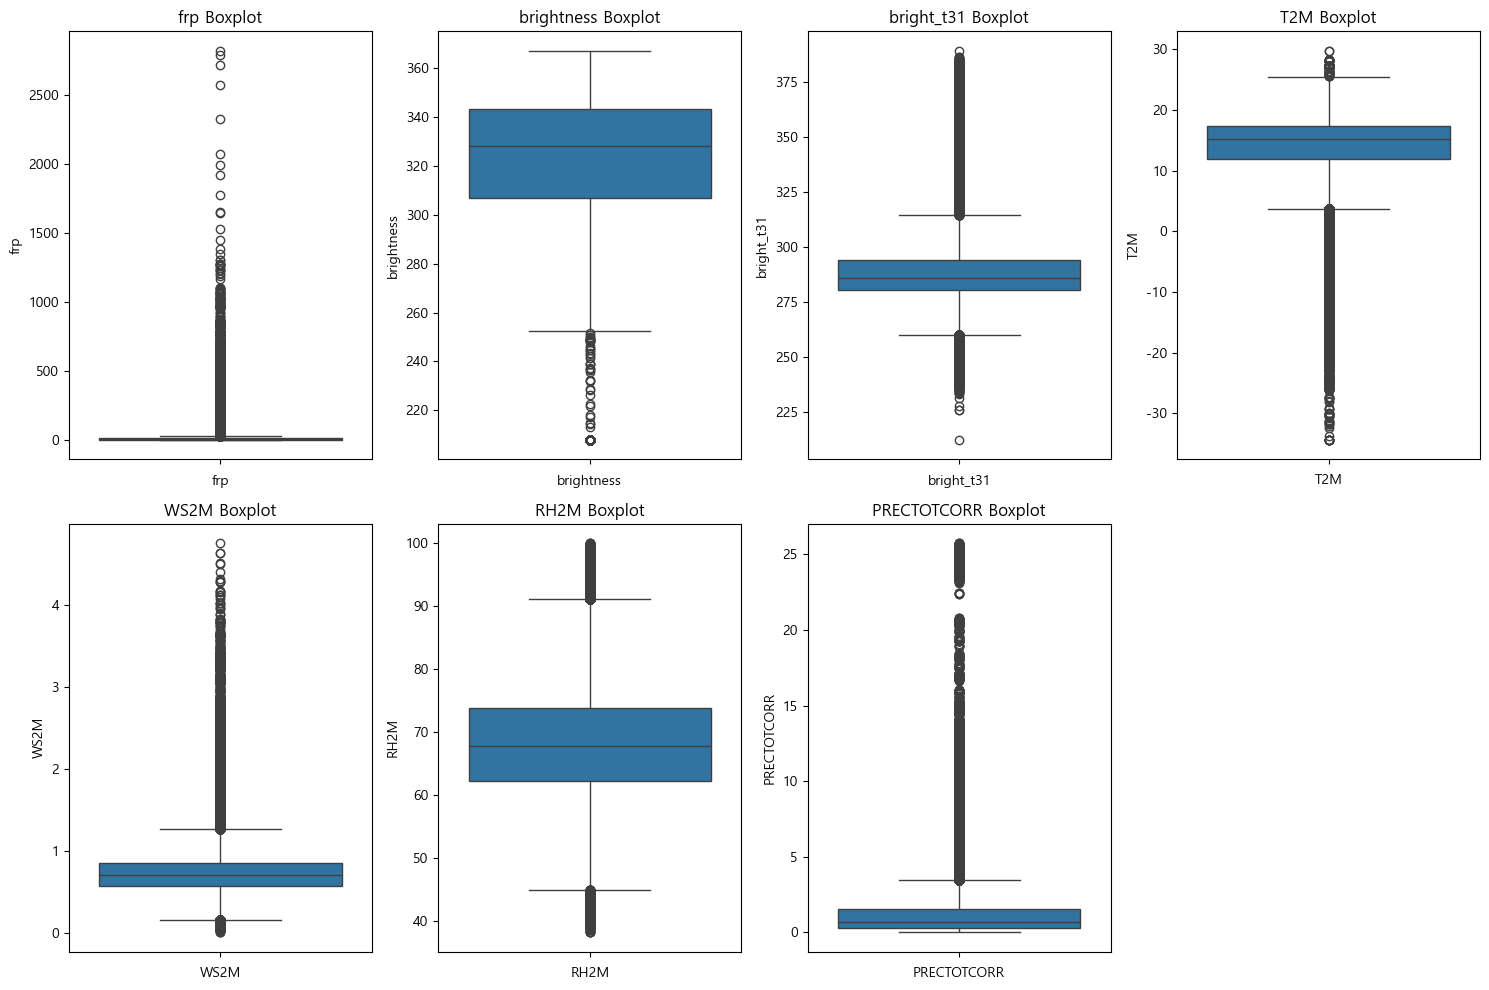

In [5]:
# 여러 변수에 대해 boxplot을 한 번에 그리기
plt.figure(figsize=(15, 10))

# 각 변수에 대해 Boxplot 생성
variables = ["frp", "brightness", "bright_t31", "T2M", "WS2M", "RH2M", "PRECTOTCORR"]
for i, v in enumerate(variables, 1):
    plt.subplot(2, 4, i) # 2행 4열
    sns.boxplot(merged_wildfire_df[v])
    plt.title(f"{v} Boxplot")
    plt.xlabel(v)

plt.tight_layout()
plt.show()


### 해석
# frp, bright_t31, PRECTOTCORR에서 상당한 수의 이상치(위쪽 점들이 많음)가 존재.
# WS2M(풍속)과 RH2M(습도)도 이상치 존재 → 극단적인 기상 조건에서 산불이 발생했을 가능성이 있음.
# brightness는 상대적으로 이상치가 적고, 비교적 안정적인 분포를 가짐.
# PRECTOTCORR(강수량)에서 극단적으로 높은 값들이 존재 → 이상치 처리가 필요할 수도 있음.

In [6]:
# 이상치 처리 함수
def handle_outliers(df):
    # FRP (Fire Radiative Power) 처리
    df['frp'] = df['frp'].clip(lower=0)  # FRP는 0 이상만 유지

    # Brightness 처리: 너무 낮거나 높은 값만 클리핑
    df['brightness'] = df['brightness'].clip(lower=250.7, upper=402.7)  # 상한선 수정

    # Bright_t31 처리: 설정한 범위로 클리핑
    df['bright_t31'] = df['bright_t31'].clip(lower=265.0, upper=319.995)

    # T2M (기온)은 이상치가 없으므로 그대로 둡니다.
    
    # WS2M (2m 높이 풍속) 처리: 상한선만 설정
    df['WS2M'] = df['WS2M'].clip(lower=0)

    # RH2M (2m 높이 상대습도) 처리
    df['RH2M'] = df['RH2M'].clip(lower=0, upper=100)  # RH2M의 상한선을 100으로 클리핑 (100%를 초과하는 값은 오류일 가능성 있음)

    # PRECTOTCORR (교정된 총 강수량)은 설정한 범위로 클리핑
    df['PRECTOTCORR'] = df['PRECTOTCORR'].clip(lower=0)

    return df


# 이상치 처리
cleaned_wildfire_df = handle_outliers(merged_wildfire_df)

# 처리 후 데이터 확인
print(cleaned_wildfire_df[['frp', 'brightness', 'bright_t31', 'T2M', 'WS2M', 'RH2M', 'PRECTOTCORR']].head())

# 데이터 타입 확인
print(cleaned_wildfire_df.dtypes)  # 이제 불필요한 컬럼이 제거되었는지 확인


     frp  brightness  bright_t31       T2M      WS2M       RH2M  PRECTOTCORR
0   1.86      304.51      265.00 -6.322006  0.916922  94.762712     2.531720
1   1.80      311.48      265.00 -6.328954  0.916536  94.764172     2.530994
2   2.44      327.22      266.04 -7.068858  1.012001  96.727194     2.519868
3  29.80      351.23      275.81 -6.068124  0.789605  97.041587     2.702035
4  32.28      336.25      274.76 -6.067059  0.788058  97.046200     2.702251
latitude              float64
longitude             float64
brightness            float64
confidence             object
bright_t31            float64
frp                   float64
daynight               object
T2M                   float64
WS2M                  float64
RH2M                  float64
PRECTOTCORR           float64
datetime       datetime64[ns]
dtype: object


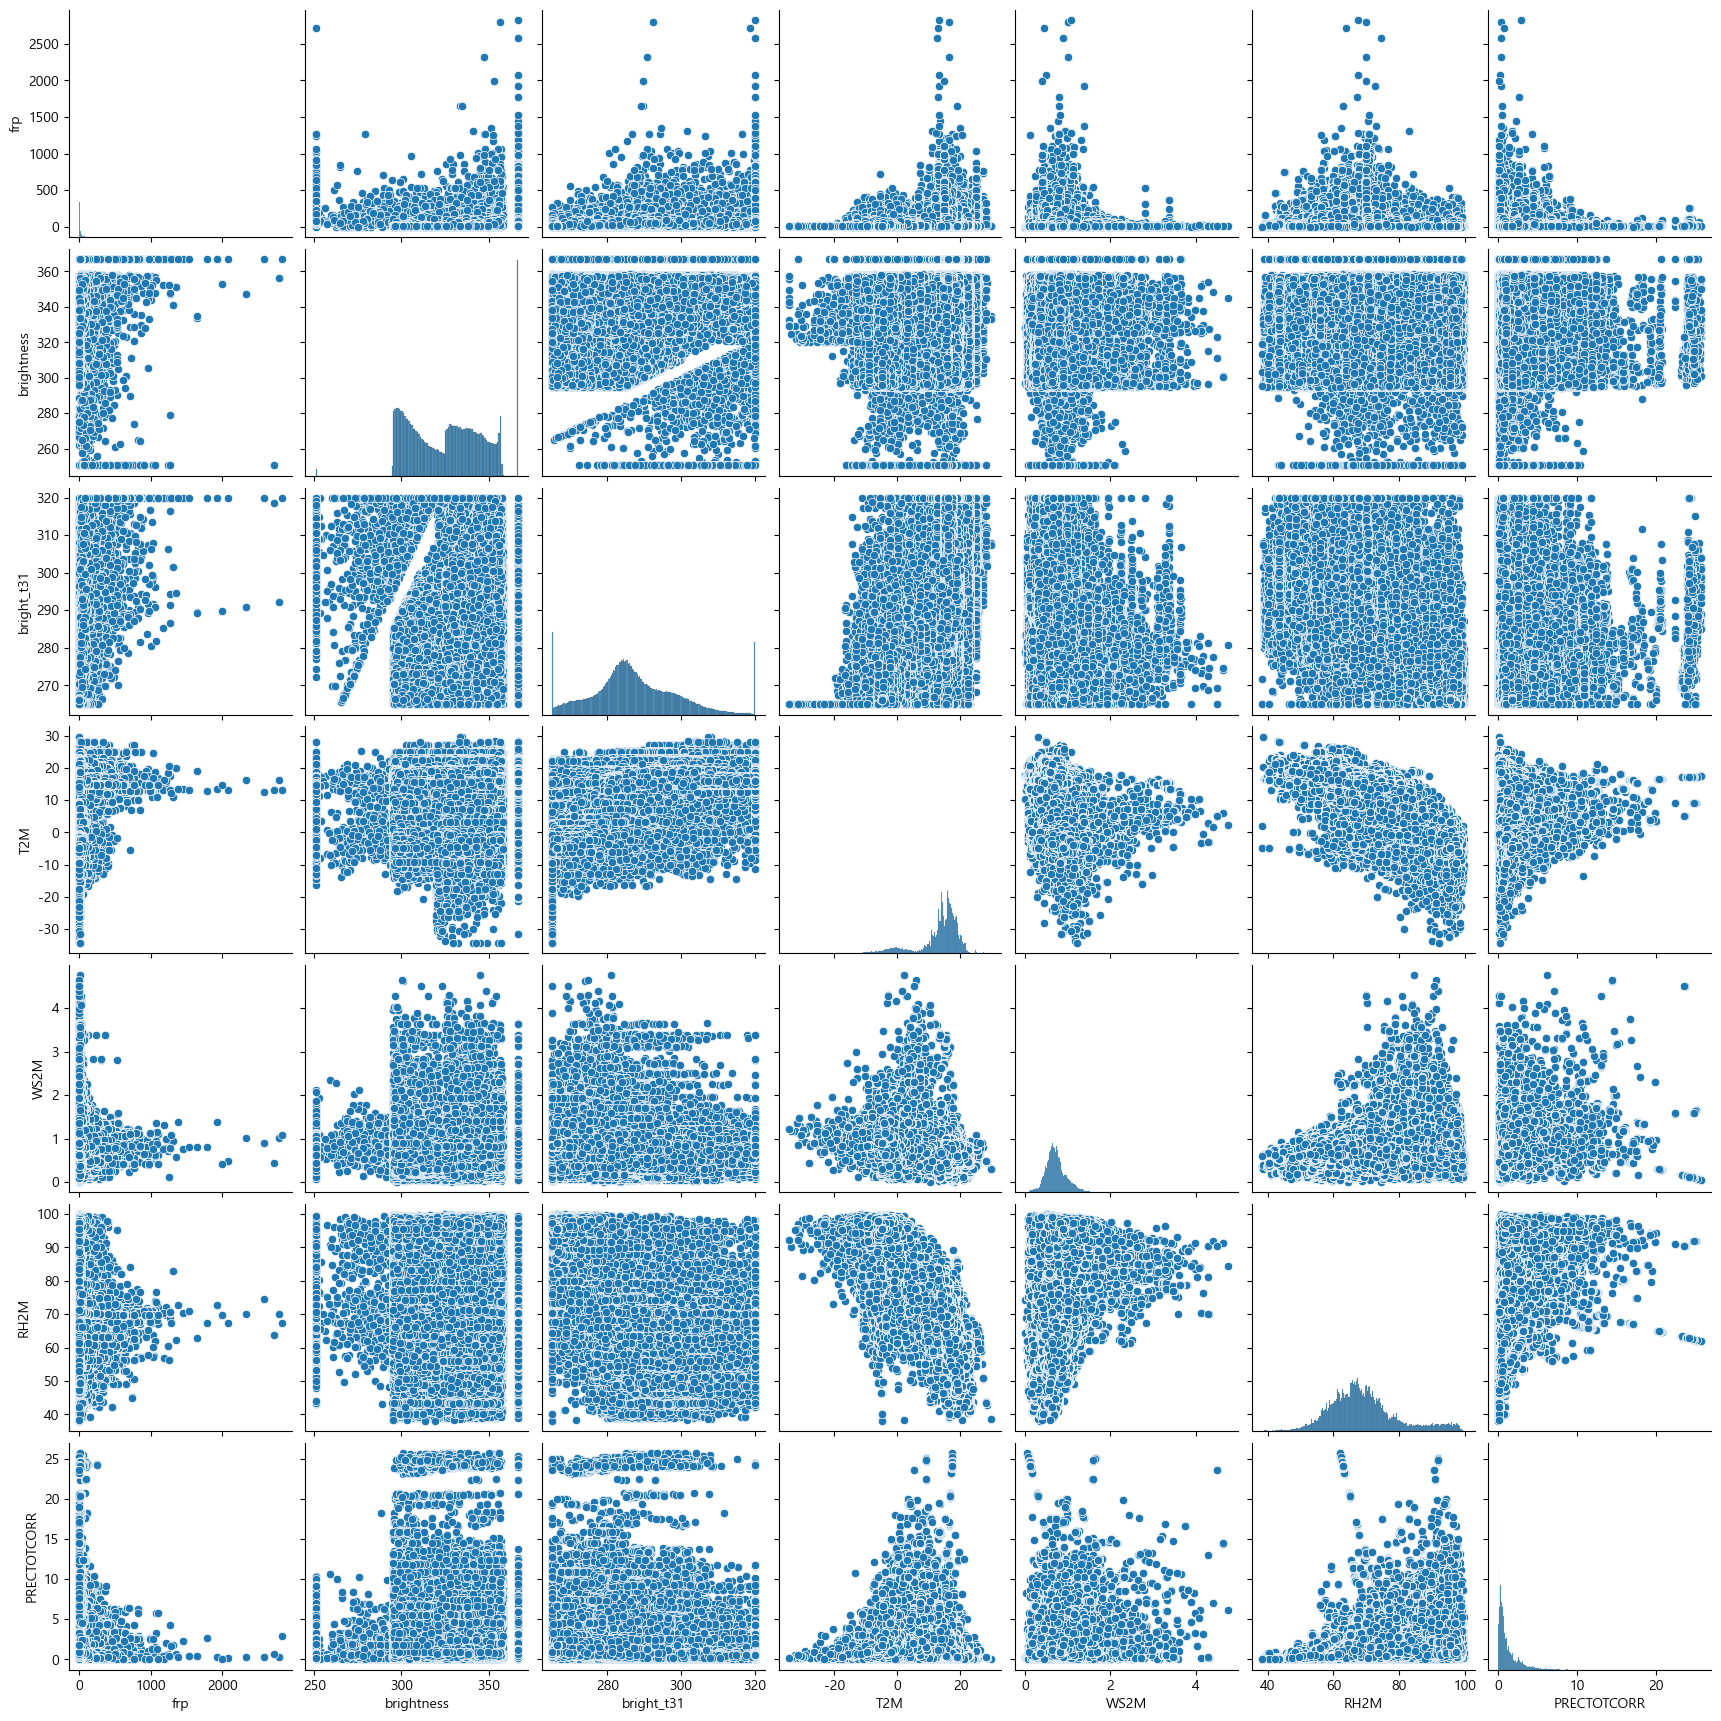

In [7]:
# 선택한 컬럼들로 Pairplot 시각화
selected_columns = ["frp", "brightness", "bright_t31", "T2M", "WS2M", "RH2M", "PRECTOTCORR"]
sns.pairplot(cleaned_wildfire_df[selected_columns])
plt.show()

###  Pairplot 해석 (변수 간 관계 분석)
# frp vs brightness, frp vs bright_t31에서 약한 양의 선형 관계 보임.
# RH2M(습도)와 T2M(기온)에서 음의 상관관계가 시각적으로 드러남.
# PRECTOTCORR(강수량)는 대부분의 변수와 선형적인 관계가 거의 없음 → 회귀 분석 시 비선형 변환을 고려할 필요가 있음.

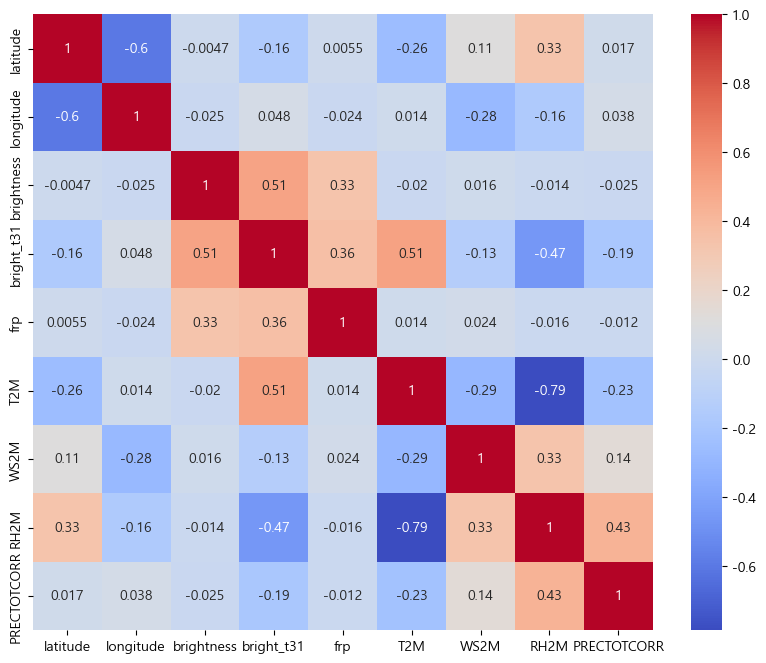

In [8]:
# 상관 관계 시각화
corr = cleaned_wildfire_df.drop(columns=["confidence", "daynight", "datetime"]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

# 해설
# brightness와 bright_t31은 0.67로 강한 양의 상관관계를 보임 → 밝은 불꽃일수록 높은 온도를 가짐.
# frp와 brightness(0.35), bright_t31(0.4)도 양의 상관관계를 가짐 → 더 밝고 뜨거운 불꽃일수록 에너지가 큼.
# RH2M(습도)와 T2M(기온)은 -0.61의 음의 상관관계 → 일반적으로 기온이 높을수록 습도는 낮아짐.
# PRECTOTCORR(강수량)과 대부분의 변수 간 상관관계는 낮음 → 강수량이 FRP에 미치는 영향이 약하거나, 직접적인 관계보다는 시차 효과가 있을 가능성.


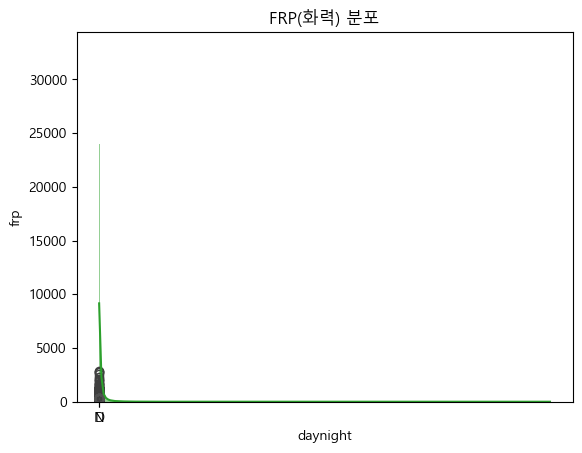

In [9]:
# 산불 데이터의 분포 확인
sns.boxplot(x="daynight", y="frp", data=cleaned_wildfire_df)
sns.boxplot(x="daynight", y="brightness", data=cleaned_wildfire_df)

# 산불 강도(frp)의 분포 확인
sns.histplot(cleaned_wildfire_df['frp'], kde=True)
plt.title("FRP(화력) 분포")
plt.show()

# 해석
# 3. FRP(화력) vs 주야간(daynight)
# 그래프에서 N(Night)에 데이터가 몰려 있으며, 야간의 FRP 값이 낮은 경우가 많음.
# 낮(Day)의 데이터가 상대적으로 적거나 시각적으로 표현되지 않은 것으로 보임.
# 야간에는 화재 감지 빈도가 낮거나, 산불이 더 적게 발생하는 경향이 있을 수 있음.

# 야간 vs 주간 FRP:
# 야간에는 화재 감지가 어려울 가능성이 있고, 실제로도 낮보다 낮은 FRP 값을 보임.


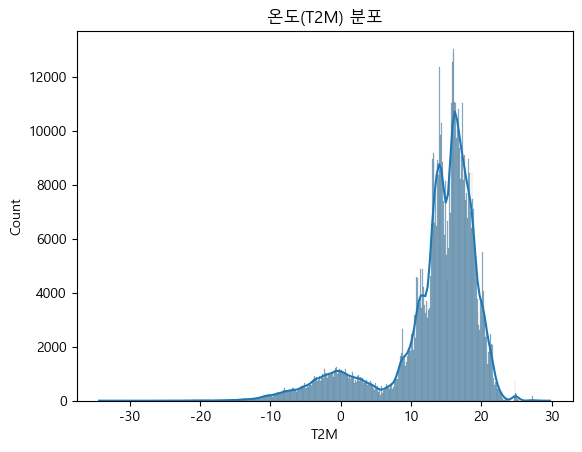

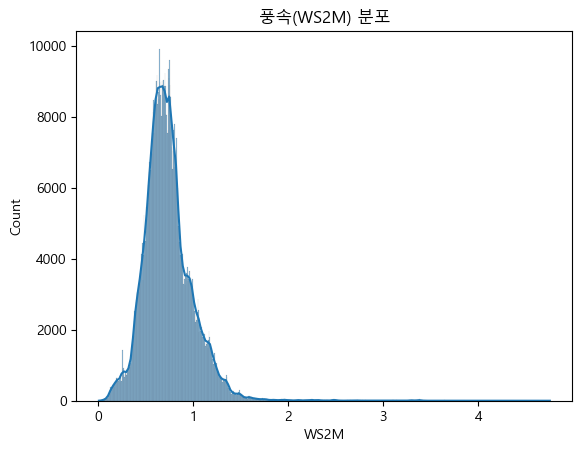

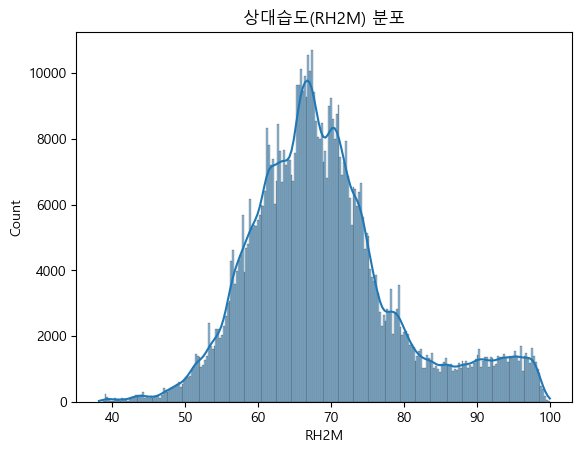

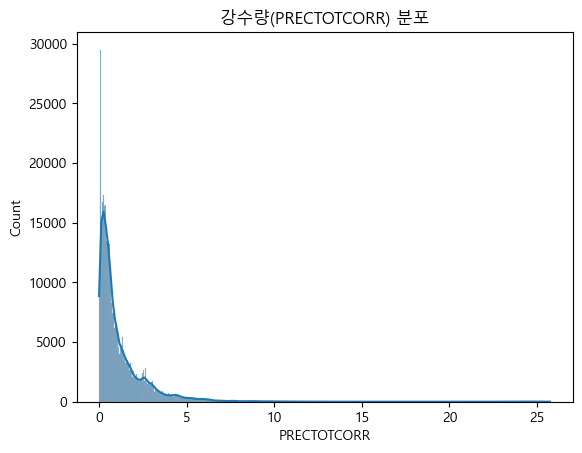

In [10]:
# 기상 변수의 분포 확인
sns.histplot(cleaned_wildfire_df["T2M"], kde=True)
plt.title('온도(T2M) 분포')
plt.show()

sns.histplot(cleaned_wildfire_df['WS2M'], kde=True)
plt.title('풍속(WS2M) 분포')
plt.show()

sns.histplot(cleaned_wildfire_df['RH2M'], kde=True)
plt.title('상대습도(RH2M) 분포')
plt.show()

sns.histplot(cleaned_wildfire_df['PRECTOTCORR'], kde=True)
plt.title('강수량(PRECTOTCORR) 분포')
plt.show()

# 데이터 분포 해석
# 1. 온도 (T2M) 분포
# 전반적으로 정규 분포 형태를 보이며, 20°C 부근에서 가장 빈도가 높음.
# 오른쪽 꼬리가 길어 고온 구간의 데이터가 일부 포함됨.
# 시각적으로 이상치는 많지 않아 보임.

# 2. 풍속 (WS2M) 분포
# 0~2m/s 구간에서 가장 빈도가 높으며, 비대칭적인 오른쪽 꼬리 분포(right-skewed).
# 풍속이 낮은 경우가 압도적으로 많음.
# 2.5m/s 이상은 상대적으로 드물어 보임. 기상은 매번 다르니 이상치라 판단하기  어려움

# 3. 상대습도 (RH2M) 분포
# 20~40%에서 가장 많은 데이터가 분포하며, 전체적으로 왼쪽으로 치우친 분포(left-skewed).
# 100%에 가까운 값도 일부 존재함.
# 습도가 낮은 지역에서의 데이터가 많은 것으로 추정됨.

# 4. 강수량 (PRECTOTCORR) 분포
# 대부분의 데이터가 0에 몰려 있고, 일부 극단적으로 높은 값이 있음.
# 강수량 데이터가 편향되어 있으며, 0이 많은 희소 데이터(sparse data)로 보임.
# 로그 변환(log1p)을 적용하면 정규성 개선 가능.


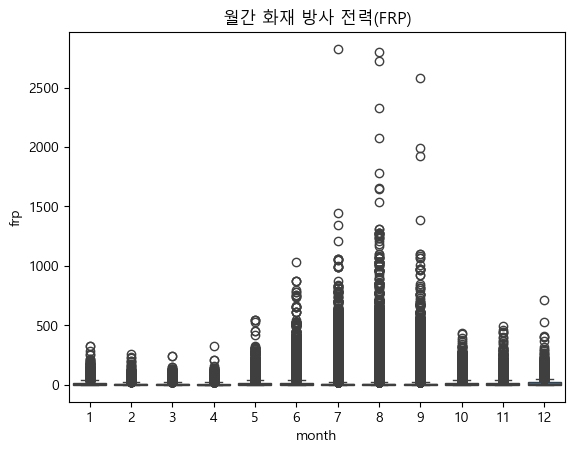

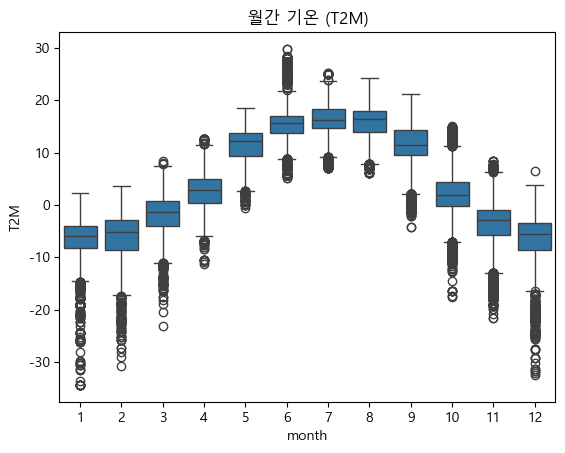

In [11]:
# 날짜와 시간대별 분포 분석
cleaned_wildfire_df["datetime"] = pd.to_datetime(cleaned_wildfire_df["datetime"])
cleaned_wildfire_df["year"] = cleaned_wildfire_df["datetime"].dt.year
cleaned_wildfire_df["month"] = cleaned_wildfire_df["datetime"].dt.month
cleaned_wildfire_df["day"] = cleaned_wildfire_df["datetime"].dt.day

# 월별 화재 방사 전력(FRP) 분석
sns.boxplot(x="month", y="frp", data=cleaned_wildfire_df)
plt.title("월간 화재 방사 전력(FRP)")
plt.show()

# 월별 기온(T2M) 분석
sns.boxplot(x="month", y="T2M", data=cleaned_wildfire_df)
plt.title("월간 기온 (T2M)")
plt.show()


### 월간 화재 방사 전력(FRP) 박스플롯 해석
# 1. 월간 기온(T2M) 박스플롯
# 여름(6~8월) 동안 기온이 가장 높으며, 중앙값이 20~30도 사이에 위치.
# 겨울(12~2월) 동안 기온이 가장 낮으며, 중앙값이 0~10도 사이.
# 월별로 기온 변동 폭이 다름. 특히 여름에는 이상치(Outliers)가 많아 기온 변화가 상대적으로 큼.

# 2. 월간 화재 방사 전력(FRP) 분포
# 여름(6~9월)에 FRP(화재 강도)가 증가하는 경향을 보임.
# 8월에 가장 많은 화재가 발생하며, 극단적인 FRP 값(1000 이상)도 다수 존재.
# 겨울철(1~5월, 10~12월)에는 상대적으로 낮은 FRP 값을 보이며, 강한 산불이 적은 것으로 보임.

# 기온과 산불 강도(FRP)의 관계:
# 여름철(6~9월)에 기온이 상승함에 따라 화재 발생과 강도가 증가하는 경향이 뚜렷함.


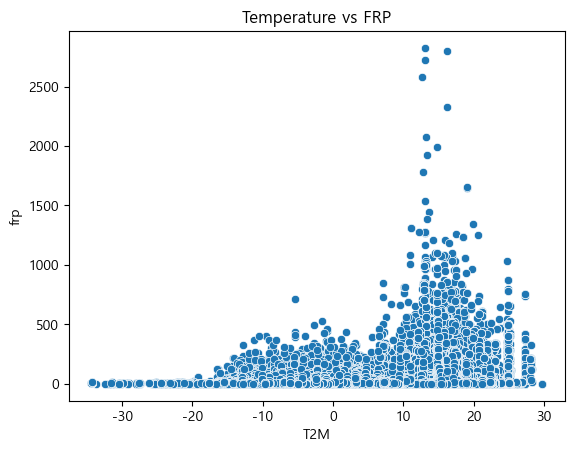

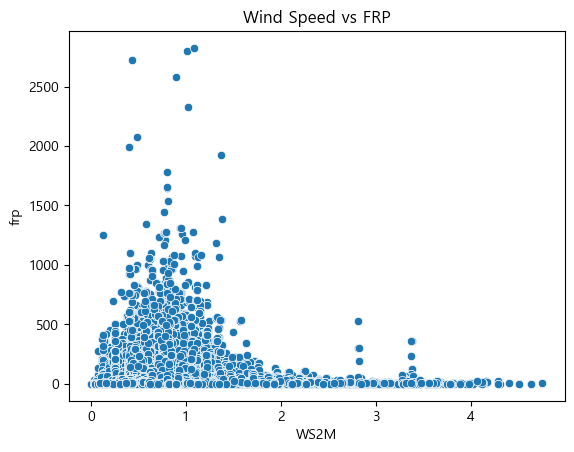

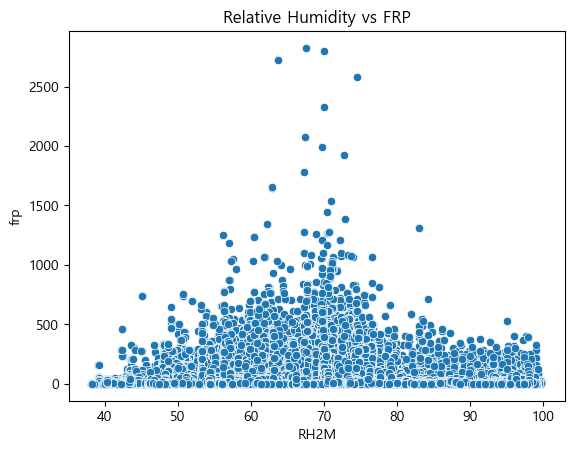

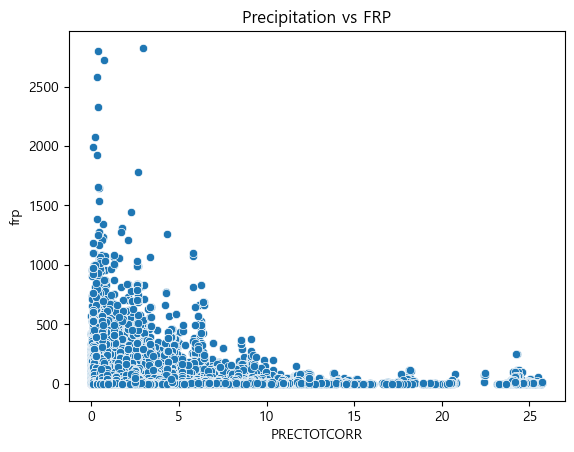

In [12]:
# 기온(T2M)과 화재 방사 전력(FRP) 간의 관계
sns.scatterplot(x="T2M", y="frp", data=cleaned_wildfire_df)
plt.title("Temperature vs FRP")
plt.show()

# 풍속(WS2M)과 화재 방사 전력(FRP) 간의 관계
sns.scatterplot(x="WS2M", y="frp", data=cleaned_wildfire_df)
plt.title("Wind Speed vs FRP")
plt.show()

# 상대 습도(RH2M)와 화재 방사 전력(FRP) 간의 관계
sns.scatterplot(x="RH2M", y="frp", data=cleaned_wildfire_df)
plt.title("Relative Humidity vs FRP")
plt.show()

# 강수량(PRECTOTCORR)과 화재 방사 전력(FRP) 간의 관계
sns.scatterplot(x="PRECTOTCORR", y="frp", data=cleaned_wildfire_df)
plt.title("Precipitation vs FRP")
plt.show()

# 산불 데이터 시각화 해석
# 1. Temperature vs FRP (기온 vs 화재 방사 전력)
# T2M(기온)과 FRP(화재 방사 전력) 사이의 관계를 나타냄.
# 기온이 15~30도 사이에서 FRP 값이 높은 분포를 보임.
# 0도 이하에서는 화재 발생이 거의 없는 것으로 보임.
# 해석: 기온이 높을수록 화재가 더 강하게 발생할 가능성이 높아짐. 
#       특히 15~30도 사이에서 화재 강도가 두드러지는 것은 실제 산불 발생과 관련이 있을 수 있음.

# 2. Wind Speed vs FRP (풍속 vs 화재 방사 전력)
# WS2M(2m 높이의 풍속)과 FRP 사이의 관계를 나타냄.
# 풍속이 0~3m/s 구간에서 FRP가 높은 분포를 보임.
# 풍속이 5m/s 이상일 때는 FRP 값이 상대적으로 낮아지는 경향을 보임.
# 해석: 풍속이 0~3m/s일 때 산불 강도가 높아지는 것으로 보이며, 이는 바람이 산불 확산에 영향을 미치기 때문일 가능성이 있음. 
#       하지만 풍속이 너무 강해지면 화재 확산이 어려워져 FRP가 낮아지는 것으로 추측됨.

# 3. Relative Humidity vs FRP (습도 vs 화재 방사 전력)
# RH2M(상대습도)과 FRP 사이의 관계를 보여줌.
# 습도가 낮을수록 FRP가 높은 경향을 보임.
# 습도가 20~40%일 때 FRP가 높은 값으로 분포하는 경향이 있음.
# 해석: 습도가 낮을수록 화재 강도가 강해지는 것을 의미함. 
#       건조한 환경에서는 화재가 더 쉽게 발생하고 강한 산불로 이어질 가능성이 큼.

# 4. Precipitation vs FRP (강수량 vs 화재 방사 전력)
# PRECTOTCORR(강수량)과 FRP(화재 방사 전력) 사이의 관계를 보여주는 산점도.
# 강수량이 많을수록 FRP 값이 낮아지는 경향을 보임.
# 특히 강수량이 0~5mm 수준일 때 FRP 값이 높게 나타남.
# 해석: 강수량이 증가할수록 화재 발생 강도가 낮아지는 경향이 있음. 이는 예상 가능한 결과로, 
#       비가 많이 올수록 화재가 발생하거나 강하게 타오를 가능성이 줄어든다고 볼 수 있음.

# 종합적인 해석
# 강수량이 적고, 기온이 높으며, 바람이 적당히 불고, 습도가 낮을수록 화재가 강하게 발생하는 경향을 보임.
# 특히, 기온 1530도, 습도 2040%, 강수량 05mm, 풍속 03m/s일 때 FRP 값이 높은 분포를 보임.
# 이 결과를 바탕으로 머신러닝 모델을 학습할 때, 주요 변수로 강수량, 기온, 풍속, 습도를 활용하면 유의미한 예측이 가능할 것으로 보임.

# 캐나다 브리시티 시각화

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3840\2284270587.py:8: DtypeWarning: Columns (22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv("./merged_fire.csv")


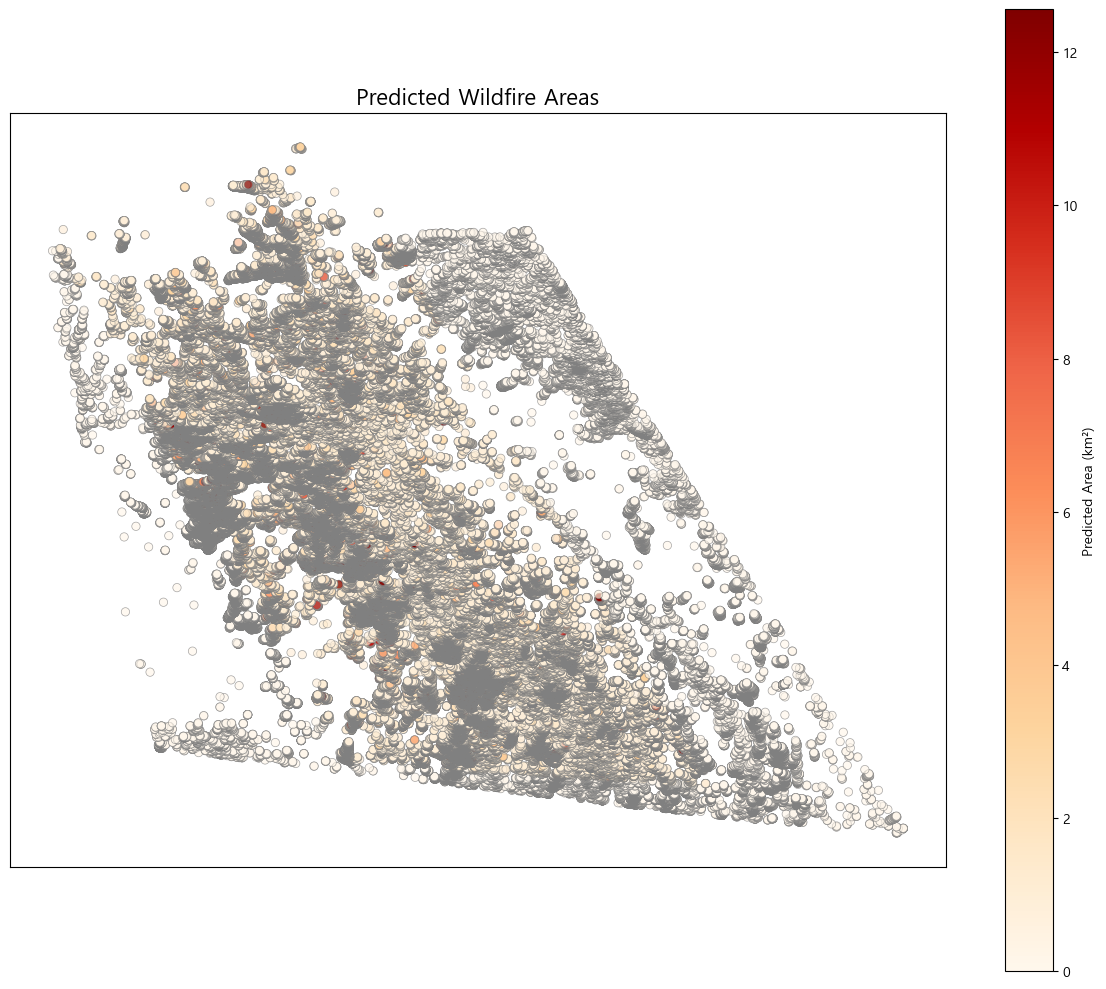

In [14]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point 

# 1. merged_fire.csv 로드 및 GeoDataFrame 변환
merged_df = pd.read_csv("./merged_fire.csv")
# geometry를 Point 객체로 변환
merged_df['geometry'] = merged_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
merged_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry', crs="EPSG:4326")

# 2. 데이터 보정 (ValueError 방지)
# frp 값 보정: NaN 또는 inf를 0으로 대체
merged_gdf['frp'] = merged_gdf['frp'].replace([np.inf, -np.inf], np.nan).fillna(0)
# acq_date 처리
if 'acq_date' not in merged_gdf.columns:
    print("Warning: 'acq_date' not found, using placeholder")
    merged_gdf['acq_date'] = "Unknown"
else:
    merged_gdf['acq_date'] = pd.to_datetime(merged_gdf['acq_date'], errors='coerce').dt.strftime('%Y-%m-%d %H:%M:%S')

# 3. GeoPandas로 기본 지도 시각화 (검은색 테두리 조정)
fig, ax = plt.subplots(figsize=(12, 10))
merged_gdf.plot(
    ax=ax,
    column='predicted_area_km2',
    cmap='OrRd',
    edgecolor='gray',           # 검은색 대신 회색
    linewidth=0.5,              # 테두리 두께 줄임
    alpha=0.7,
    legend=True,
    vmin=0,
    vmax=12.566,
    legend_kwds={'label': "Predicted Area (km²)", 'orientation': "vertical"}
)
ax.set_title("Predicted Wildfire Areas", fontsize=16)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
import webbrowser
from folium.plugins import MarkerCluster

# 4. Folium으로 인터랙티브 지도 시각화 (당신의 HTML 스타일 유지)
# 샘플링 (10% 사용)
merged_gdf_sample = merged_gdf.sample(frac=0.1, random_state=42)

# 지도 생성 (당신의 스타일: 기본 타일, 브리티시 컬럼비아 중심)
m = folium.Map(location=[53.7267, -127.6476], zoom_start=6)  # 기본 타일 사용
marker_cluster = MarkerCluster().add_to(m)

# GeoJSON 변환 및 팝업 설정
geojson_data = merged_gdf_sample.to_json()
folium.GeoJson(
    geojson_data,
    name="Fire Detection",
    style_function=lambda x: {
        'fillColor': 'red',        # 빨간색 채우기 유지
        'color': 'gray',           # 검은색 대신 회색으로 변경
        'weight': 0.5,             # 테두리 두께 줄여 시각성 개선
        'fillOpacity': 0.6         # 약간 투명하게
    },
    popup=folium.features.GeoJsonPopup(
        fields=['predicted_area_km2', 'acq_date', 'frp'],
        aliases=['Predicted Area (km²)', 'Date', 'FRP'],
        localize=True,
        labels=True
    )
).add_to(marker_cluster)

# 지도 저장 및 열기
output_file = "fire_map_geojson.html"
m.save(output_file)
file_path = os.path.abspath(output_file)
webbrowser.open(f"file://{file_path}")

print(f"Map saved as {output_file} and opened in browser")

Map saved as fire_map_geojson.html and opened in browser


In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from scipy.stats import spearmanr


from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor


import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import set_config
import joblib  # 모델 저장용

from model_class import Models

In [20]:
wildfire = pd.read_csv("./merged_fire.csv")
wildfire.info()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3840\3829749581.py:1: DtypeWarning: Columns (22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  wildfire = pd.read_csv("./merged_fire.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727273 entries, 0 to 727272
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   latitude               727273 non-null  float64
 1   longitude              727273 non-null  float64
 2   brightness             718628 non-null  float64
 3   bright_t31             718628 non-null  float64
 4   frp                    718628 non-null  float64
 5   T2M                    718628 non-null  float64
 6   WS2M                   718628 non-null  float64
 7   RH2M                   718628 non-null  float64
 8   PRECTOTCORR            718628 non-null  float64
 9   year                   718628 non-null  float64
 10  month                  718628 non-null  float64
 11  day                    718628 non-null  float64
 12  confidence_h           718628 non-null  float64
 13  confidence_l           718628 non-null  float64
 14  confidence_n           718628 non-nu

In [21]:
# 데이터를 병합 하며 결측치가 생겨 결측값 제거
wildfire = wildfire.dropna()

# 독립 변수(X): float64 타입만 추출, predicted_area_km2 제외
numeric_columns = wildfire.select_dtypes(include=['float64']).columns
X = wildfire[numeric_columns.drop('predicted_area_km2')]
y = wildfire['predicted_area_km2']

# 스피어만 상관계수 계산
print("스피어만 상관관계 분석 결과 (결측값 제거 후):")
print("-" * 50)

for value in X.columns:
    statistic, pvalue = spearmanr(X[value], y)
    
    # 출력
    if pvalue < 0.05 and abs(statistic) >= 0.2:
        print(f"상관관계 계수 {statistic:.3f}, p-value {pvalue:.4f} : ({value})는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)")
    elif pvalue < 0.05:
        print(f"상관관계 계수 {statistic:.3f}, p-value {pvalue:.4f} : ({value})는 predicted_area_km2에 대해 약한 상관관계 (유의미)")
    else:
        print(f"상관관계 계수 {statistic:.3f}, p-value {pvalue:.4f} : ({value})는 predicted_area_km2에 대해 유의미하지 않다")

print("-" * 50)

스피어만 상관관계 분석 결과 (결측값 제거 후):
--------------------------------------------------
상관관계 계수 0.111, p-value 0.0000 : (latitude)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.189, p-value 0.0000 : (longitude)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 0.550, p-value 0.0000 : (brightness)는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)
상관관계 계수 0.327, p-value 0.0000 : (bright_t31)는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)
상관관계 계수 0.686, p-value 0.0000 : (frp)는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)
상관관계 계수 0.061, p-value 0.0000 : (T2M)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.071, p-value 0.0000 : (WS2M)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.061, p-value 0.0000 : (RH2M)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.044, p-value 0.0000 : (PRECTOTCORR)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.048, p-value 0.0000 : (year)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 0.006, p-value 0.0000 : (month)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.010, p-value 0.0000 : (da

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3840\1730802497.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  statistic, pvalue = spearmanr(X[value], y)


In [24]:
train_cols = [
    "frp",           # 강한 상관관계
    "brightness",    # 강한 상관관계
    "bright_t31",    # 강한 상관관계
    "confidence_h",  # 강한 상관관계
    "confidence_l",  # 강한 상관관계
    "confidence_n",  # 강한 상관관계
    "daynight_D",    # 강한 상관관계
    "daynight_N",    # 강한 상관관계
    "latitude",      # 약한 상관관계
    "longitude",     # 약한 상관관계
    "T2M",           # 약한 상관관계
    "WS2M",          # 약한 상관관계
    "RH2M",          # 약한 상관관계
    "PRECTOTCORR",   # 약한 상관관계
    "year",          # 약한 상관관계
    "month",         # 약한 상관관계
    "day",           # 약한 상관관계
    "season",        # 약한 상관관계
    "weekday",       # 약한 상관관계
    "WS2M_RH2M_interaction",  # 약한 상관관계
    "high_temperature",       # 약한 상관관계
    "precipitation_flag"      # 약한 상관관계
]

wildfire = wildfire.loc[:100000]

# 데이터 준비
train = wildfire[train_cols]
target = wildfire["predicted_area_km2"]

# 첫 번째 분할 (훈련 데이터와 검증 데이터)
train_input, val_input, train_target, val_target = train_test_split(train, target, test_size=0.4, random_state=42, shuffle=True)

# 두 번째 분할 (검증 데이터와 테스트 데이터)
val_input, test_input, val_target, test_target = train_test_split(val_input, val_target, test_size=0.5, random_state=42, shuffle=True)

print(train_input.shape, train_target.shape)
print(val_input.shape, val_target.shape)
print(test_input.shape, test_target.shape)

(59995, 22) (59995,)
(19998, 22) (19998,)
(19999, 22) (19999,)


In [ ]:
# 데이터 양이 너무 많아 100,000건만 훈련시켜 보겠다.

In [25]:
models = Models()
models.total_models(train_input, train_target, val_input, val_target, test_input, test_target)

Tuning and training RandomForest with None...
Best Parameters for RandomForest: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 20}
-*** RandomForest with None ***-
훈련: 0.9976, 검증: 0.9942, 테스트: 0.9916, 과적합여부: 0.0034
사용 가능한 모델입니다 (일반화).

Saved RandomForest with None as final model.
Tuning and training HistGradientBoosting with None...
Best Parameters for HistGradientBoosting: {'max_iter': 200, 'max_depth': 5, 'learning_rate': 0.1}
-*** HistGradientBoosting with None ***-
훈련: 0.9930, 검증: 0.9901, 테스트: 0.9883, 과적합여부: 0.0029
사용 가능한 모델입니다 (일반화).

Saved HistGradientBoosting with None as final model.
Tuning and training XGB with None...
Best Parameters for XGB: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1}
-*** XGB with None ***-
훈련: 0.9987, 검증: 0.9935, 테스트: 0.9896, 과적합여부: 0.0053
사용 가능한 모델입니다 (일반화).

Saved XGB with None as final model.
Tuning and training RandomForest with Standard...
Best Parameters for RandomForest: {'n_estimators': 200, 'min_sample

In [27]:
results_df = models.get_results()
results_df


,model_nm,Scaler,GSCV,train_score,val_score,test_score,과적합여부,사용,train_mae,train_mse,train_r2,val_mae,val_mse,val_r2,test_mae,test_mse,test_r2
0,RandomForest,None,Y,0.997624,0.994194,0.991630,0.003430,Y,0.004775,0.005272,0.997624,0.008918,0.012697,0.994194,0.010289,0.018134,0.991630
1,HistGradientBoosting,None,Y,0.993040,0.990139,0.988262,0.002901,Y,0.034941,0.015445,0.993040,0.038881,0.021566,0.990139,0.038649,0.025428,0.988262
2,XGB,None,Y,0.998740,0.993453,0.989575,0.005287,Y,0.017429,0.002796,0.998740,0.024307,0.014319,0.993453,0.025176,0.022585,0.989575
3,RandomForest,Standard,Y,0.997633,0.994194,0.991665,0.003439,Y,0.004771,0.005253,0.997633,0.008930,0.012699,0.994194,0.010263,0.018056,0.991665
4,HistGradientBoosting,Standard,Y,0.993040,0.990139,0.988262,0.002901,Y,0.034941,0.015445,0.993040,0.038881,0.021566,0.990139,0.038649,0.025428,0.988262
5,XGB,Standard,Y,0.998740,0.993453,0.989575,0.005287,Y,0.017429,0.002796,0.998740,0.024307,0.014319,0.993453,0.025176,0.022585,0.989575
6,RandomForest,MinMax,Y,0.997626,0.994212,0.991625,0.003413,Y,0.004774,0.005268,0.997626,0.008918,0.012658,0.994212,0.010282,0.018143,0.991625
7,HistGradientBoosting,MinMax,Y,0.993040,0.990139,0.988262,0.002901,Y,0.034941,0.015445,0.993040,0.038881,0.021566,0.990139,0.038649,0.025428,0.988262
8,XGB,MinMax,Y,0.998740,0.993453,0.989575,0.005287,Y,0.017429,0.002796,0.998740,0.024305,0.014319,0.993453,0.025176,0.022585,0.989575
9,RandomForest,Robust,Y,0.997623,0.994183,0.991620,0.003440,Y,0.004773,0.005275,0.997623,0.008924,0.012723,0.994183,0.010278,0.018155,0.991620


In [ ]:
# 가장 좋은 모델은
# XGB	None	Y	0.998740	0.993453	0.989575	0.005287	Y	0.017429	0.002796	0.998740	0.024307	0.014319	0.993453	0.025176	0.022585	0.989575
# XGB	Standard	Y	0.998740	0.993453	0.989575	0.005287	Y	0.017429	0.002796	0.998740	0.024307	0.014319	0.993453	0.025176	0.022585	0.989575
# XGB	MinMax	Y	0.998740	0.993453	0.989575	0.005287	Y	0.017429	0.002796	0.998740	0.024305	0.014319	0.993453	0.025176	0.022585	0.989575
# XGB	Robust	Y	0.998740	0.993453	0.989575	0.005287	Y	0.017429	0.002796	0.998740	0.024307	0.014319	0.993453	0.025176	0.022585	0.989575




In [28]:
results_df.to_csv("model_results_final.csv", index=False)

모델 로드 완료: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_3840\4054546646.py:13: DtypeWarning: Columns (22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  wildfire = pd.read_csv("./merged_fire.csv").dropna()


예측 결과 샘플: [0.03288886 0.18150361 0.03606364 0.0514965  0.0350937 ]


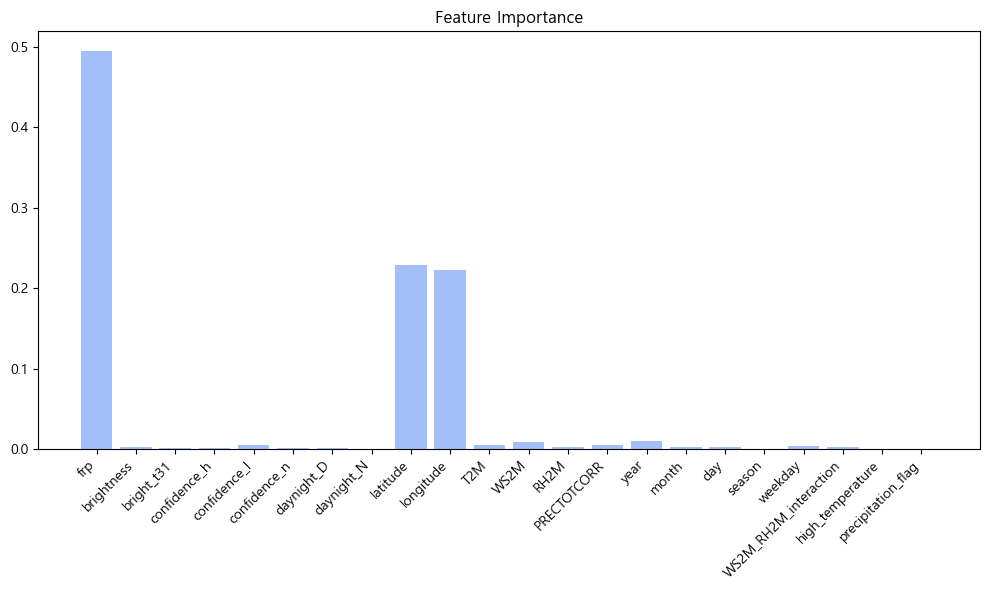

In [30]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import folium

# 모델 불러오기
model_path = "XGB_Standard_final_model.pkl"
best_model = joblib.load(model_path)
print("모델 로드 완료:", best_model)

# 데이터 준비
wildfire = pd.read_csv("./merged_fire.csv").dropna()

# 학습 때 사용한 22개 피처
train_cols = [
    "frp", "brightness", "bright_t31", "confidence_h", "confidence_l", "confidence_n",
    "daynight_D", "daynight_N", "latitude", "longitude", "T2M", "WS2M", "RH2M",
    "PRECTOTCORR", "year", "month", "day", "season", "weekday", "WS2M_RH2M_interaction",
    "high_temperature", "precipitation_flag"
]
test_data = wildfire[train_cols]

# 스케일링 (StandardScaler 사용)
scaler = StandardScaler()
scaler.fit(test_data)  # 학습 때 저장된 스케일러 없으니 새로 fit (최적은 학습 데이터로 fit)
test_scaled = scaler.transform(test_data)
predictions = best_model.predict(test_scaled)
print("예측 결과 샘플:", predictions[:5])

# 피처 중요도 분석
feature_names = train_cols
importances = best_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances, color="#A3BFFA")
plt.title("Feature Importance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()

In [32]:
# 예측 결과 시각화
wildfire_with_pred = wildfire[["latitude", "longitude"]].copy()
wildfire_with_pred["predicted_area_km2"] = predictions

m = folium.Map(location=[53.7267, -127.6476], zoom_start=5)
for idx, row in wildfire_with_pred.sample(1000).iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=max(row["predicted_area_km2"] / 1000, 1),
        color="#B2F5EA",
        fill=True,
        fill_color="#B2F5EA",
        popup=f"Predicted Area: {row['predicted_area_km2']:.2f} km²"
    ).add_to(m)
m.save("predicted_fire_map.html")
print("지도 저장 완료.")

지도 저장 완료.


In [33]:
# 지도 저장 및 열기
output_file = "fire_map_geojson.html"
m.save(output_file)
file_path = os.path.abspath(output_file)
webbrowser.open(f"file://{file_path}")

print(f"Map saved as {output_file} and opened in browser")

Map saved as fire_map_geojson.html and opened in browser


In [34]:
print(wildfire["predicted_area_km2"].describe())
print("예측값 분포:", pd.Series(predictions).describe())

count    718628.000000
mean          1.216166
std           1.752052
min           0.000000
25%           0.817417
50%           0.886051
75%           1.117145
max          12.546194
Name: predicted_area_km2, dtype: float64
예측값 분포: count    718628.000000
mean          0.912389
std           1.388058
min          -1.193707
25%           0.039586
50%           0.841763
75%           1.001809
max          13.505548
dtype: float64


In [37]:
m = folium.Map(location=[53.7267, -127.6476], zoom_start=5)
for idx, row in wildfire_with_pred.sample(100).iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=max(row["predicted_area_km2"] * 10, 1),  # 스케일 조정
        color="#FF0000",  # 빨간색으로 변경
        fill=True,
        fill_color="#FF0000",
        popup=f"Predicted Area: {row['predicted_area_km2']:.2f} km²"
    ).add_to(m)
m.save("predicted_fire_map.html")
print("지도 재저장 완료.")

지도 재저장 완료.


In [38]:
# 지도 저장 및 열기
output_file = "fire_map_geojson.html"
m.save(output_file)
file_path = os.path.abspath(output_file)
webbrowser.open(f"file://{file_path}")

print(f"Map saved as {output_file} and opened in browser")

Map saved as fire_map_geojson.html and opened in browser
